In [1]:
import numpy as np
import tensorflow as tf
import random

import param
import data
import model

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## load and prepare training images

In [2]:
[pos_db_12,_,_],neg_db_12 = data.load_db_detect_train(param.img_size_12)
print(pos_db_12.shape)
print(neg_db_12.shape)

Loading positive training db: 100 images from /var/data/AFLW/aflw/data/face_rect100.txt
Loading negative training db: 1218 images from /var/data/INRIA/
(200, 12, 12, 3)
(42630, 12, 12, 3)


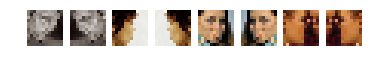

In [3]:
# plot some positive images (faces)
num_images_to_plot=8
for i in range(num_images_to_plot):
    plt.subplot(1,num_images_to_plot,i+1)
    plt.imshow(pos_db_12[i])
    plt.axis('off')

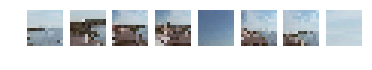

In [4]:
# plot some negative images 
for i in range(num_images_to_plot):
    plt.subplot(1,num_images_to_plot,i+1)
    plt.imshow(neg_db_12[i])
    plt.axis('off')

    

## Set up the graph

In [5]:
input_12_node = tf.placeholder("float")
target_12_node = tf.placeholder("float", [None,1])

net_12 = model.detect_12Net(input_12_node,target_12_node)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

inputs = np.zeros((param.mini_batch,param.img_size_12,param.img_size_12,param.input_channel), np.float32)
targets = np.zeros((param.mini_batch, 1), np.float32)

## Start trainig

In [ ]:
print("Training start!")
fp_loss = open("./result/12net/loss.txt", "w")
 
for epoch in range(param.epoch_num):
    
    loss = 0
    
    for it in range(param.batch_iter):

        pos_id = random.sample(range(len(pos_db_12)),param.pos_batch)
        neg_id = random.sample(range(len(neg_db_12)),param.neg_batch)

        inputs[:param.pos_batch,:] = pos_db_12[pos_id,:]
        inputs[param.pos_batch:,:] = neg_db_12[neg_id,:]
        targets[:param.pos_batch,:] = np.ones((param.pos_batch,1),np.float32)
        targets[param.pos_batch:,:] = np.zeros((param.neg_batch,1),np.float32)
        
        loss += net_12.loss.eval(feed_dict = {input_12_node:inputs, target_12_node:targets})
        net_12.train_step.run(feed_dict = {input_12_node:inputs, target_12_node:targets})

        if it > 0 and it % 3000 == 0: 
            print("epoch: " + str(epoch) + " iter: " + str(it) + "/" + str(param.batch_iter) + " loss: " + str(loss / it))

    loss /= param.batch_iter 
    fp_loss.write(str(loss)+"\n")
     
    saver = tf.train.Saver()
    saver.save(sess, param.model_dir + "12-net.ckpt")

    #test each epoch
    test_score = 0
    for bid in range(0,len(pos_db_12),param.mini_batch):

        if bid+param.mini_batch <= len(pos_db_12):
            test_inputs = pos_db_12[bid:bid+param.mini_batch,:]
            test_targets = np.ones((param.mini_batch,1),np.float32)
        else:
            test_inputs = pos_db_12[bid:,:]
            test_targets = np.ones((param.mini_batch,1),np.float32)
        
        output = net_12.prediction.eval(feed_dict = {input_12_node:test_inputs})
        test_score += np.sum(output > 0.5)

    for bid in range(0,len(neg_db_12),param.mini_batch):

        if bid+param.mini_batch <= len(neg_db_12):
            test_inputs = neg_db_12[bid:bid+param.mini_batch,:param.dim_12]
            test_targets = np.ones((param.mini_batch,1),np.float32)
        else:
            test_inputs = neg_db_12[bid:,:param.dim_12]
            test_targets = np.ones((param.mini_batch,1),np.float32)
        
        output = net_12.prediction.eval(feed_dict = {input_12_node:test_inputs})
        test_score += np.sum(output < 0.5)

    test_score /= float(len(pos_db_12)+len(neg_db_12))
    print("Accuracy: ", test_score)
    print() 

fp_loss.close()
    
        
    
 